In [16]:
%matplotlib notebook

from collections import Counter
import json
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from pycocotools.coco import COCO
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

from abyss_deep_learning.keras.classification import ClassificationDataset, FromAnnDataset, caption_map_gen, onehot_gen, augmentation_gen
from abyss_deep_learning.keras.utils import batching_gen, lambda_gen
import abyss_deep_learning.abyss_dataset as dataset_model

# Setup Data

In [ ]:
# Steve's Config
################ CONFIGURE THIS ########################
# num_classes assumed from caption_map entries
image_dims = (299, 299, 3) # Preset for InceptionV3
batch_size = 5
log_dir = "/data/log/cnn/cso"

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

# Caption type can be either "single" or "multi".
# This sets up various parameters in the system.
# If conversion between single and multi is required this should be done explicitly and presented
# in a separate json file. The internal representation of all the labels is one-hot encoding.
caption_type = "single" 
caption_map = {
    'f': 1,
    's': 0
}
coco_train = ClassificationDataset(caption_map, "/data/abyss/projectmax/cso/dataset_train.json")
coco_val = ClassificationDataset(caption_map, "/data/abyss/projectmax/cso/dataset_val.json")
coco_test = ClassificationDataset(caption_map, "/data/abyss/projectmax/cso/dataset_test.json")

In [17]:
# Jamie's Config
############### CONFIGURE THIS ########################
# num_classes assumed from caption_map entries
image_dims = (299, 299, 3) # Preset for InceptionV3
batch_size = 1 # Just supporting 1 right now
log_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/"

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

coco_train = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/training.json")
coco_val = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation.json")
coco_test = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation.json")

caption_type="multi"

caption_map_train = {cat['name']: cat['id']-1 for cat in coco_train.dataset['categories']}
print(caption_map_train)
caption_map_val = {cat['name']: cat['id']-1 for cat in coco_val.dataset['categories']}
print(caption_map_val)

caption_map = caption_map_train

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{'JD_ML': 4, 'ED_All': 2, 'JD_S': 1, 'IP': 3, 'DD': 0}
{'JD_ML': 4, 'ED_All': 2, 'JD_S': 1, 'IP': 3, 'DD': 0}


In [59]:
# coco_train.dataset['categories']

In [18]:
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = len(caption_map)
steps_per_epoch = coco_train.num_images() // batch_size
steps_per_epoch_val = coco_val.num_images() // batch_size
print("Number of classes:", num_classes)
print("Steps per epoch:", steps_per_epoch)
print("Steps per steps_per_epoch_val:", steps_per_epoch_val)
caption_map_r

Number of classes: 5
Steps per epoch: 510
Steps per steps_per_epoch_val: 181


{0: 'DD', 1: 'JD_S', 2: 'ED_All', 3: 'IP', 4: 'JD_ML'}

In [19]:
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(np.float32)), caption

def postprocess(image):
    return ((image + 1) * 127).astype(np.uint8)

def pipeline(gen, aug_config=None, from_captions=True):
    base_gen = caption_map_gen(gen, caption_map) if from_captions else gen
    return (
        augmentation_gen(
            onehot_gen(
                lambda_gen(
                    base_gen
                , func=preprocess)
            , num_classes=num_classes)
        , aug_config, enable=(aug_config is not None))
    )

def augmentation_gen(gen, aug_config, enable=True):
    '''
    Data augmentation for classification task.
    Target is untouched.
    '''
    if not enable:
        while True:
            yield from gen
    aug_list = []
    if 'flip_lr_percentage' in aug_config:
        aug_list += [iaa.Fliplr(aug_config['flip_lr_percentage'])]
    if 'flip_ud_percentage' in aug_config:
        aug_list += [iaa.Flipud(aug_config['flip_ud_percentage'])]
    if 'affine' in aug_config:
        aug_list += [iaa.Affine(**aug_config['affine'])]
#     if 'color' in aug_config: #  Color aug not working  yet
#         aug_list += [iaa.Sometimes(
#             aug_config['color']['probability'], iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(0, iaa.Add(aug_config['color']['hue'])),
#             iaa.WithChannels(1, iaa.Add(aug_config['color']['saturation'])),
#             iaa.WithChannels(2, iaa.Add(aug_config['color']['value'])),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
#         ]))]
    seq = iaa.Sequential(aug_list)
    for image, target in gen:
        yield seq.augment_image(image), target
        
aug_config = {
    'flip_lr_percentage': 0.5,
    'flip_ud_percentage': 0.5,
    'affine': {
        "order": 1,
        'scale': {
            "x": (0.8, 1.2),
            "y": (0.8, 1.2)
        },
        "rotate": (-10, 10),
        "shear": (-5, 5),
        "mode": 'constant'
    },
#     'color': {
#         'probability': 1.00,
#         'hue': (0, 0),
#         'saturation': (0, 0),
#         'value': (0, 0)
#     }
}


In [26]:
#Steve's
train_gen = pipeline(
    coco_train.generator(shuffle_ids=True),
    aug_config=aug_config)
val_gen = pipeline(coco_val.generator(shuffle_ids=True))
test_gen = pipeline(coco_test.generator(shuffle_ids=True))

In [20]:
# Jamie's
train_gen = pipeline(
    coco_train.generator(shuffle_ids=True),
    aug_config=aug_config,from_captions=False)
val_gen = pipeline(coco_val.generator(shuffle_ids=True),from_captions=False)
test_gen = pipeline(coco_test.generator(shuffle_ids=True),from_captions=False)

In [28]:
# ds = coco_val
# imgIds = [ann['image_id'] for ann in ds.loadAnns(ids=ds.getAnnIds())]
# for image_id in set(imgIds):
#     caps = [annotation['category_id']-5
#             for annotation in ds.loadAnns(ds.getAnnIds([image_id]))
#             ]
#     print(image_id,set(caps))

(299, 299, 3) [1 0 0 1 0]
(299, 299, 3) [0 0 1 1 0]
(299, 299, 3) [1 0 0 0 1]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<IPython.core.display.Javascript object>


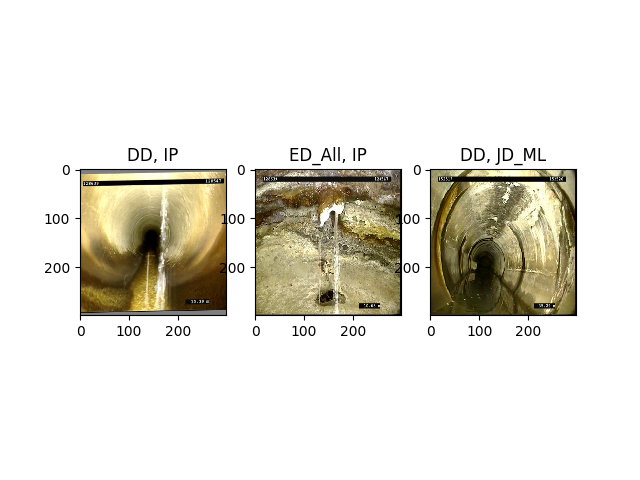

Left to right: ground truth samples from train, val test


In [21]:
for i, (train, val, test) in enumerate(zip(train_gen, val_gen, test_gen)):
    print(train[0].shape, train[1])
    print(val[0].shape, val[1])
    print(test[0].shape, test[1])
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(postprocess(train[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(train[1])]))
    
    plt.subplot(1, 3, 2)
    plt.imshow(postprocess(val[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(val[1])]))
    
    plt.subplot(1, 3, 3)
    plt.imshow(postprocess(test[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(test[1])]))
    
    if i >= 0:
        break
print("Left to right: ground truth samples from train, val test")        

In [22]:
def gen_dump_data(gen, num_images):
    data = [[],[]]
    for i, (image, caption) in enumerate(gen):
        data[0].append(image)
        data[1].append(caption)
        if i >= num_images:
            break
    data = (
        np.concatenate([i[np.newaxis, ...] for i in data[0]], axis=0),
        np.concatenate([i[np.newaxis, ...] for i in data[1]], axis=0)
    )
    return data

def count_labels_multi(data):
    return Counter([int(j) for i in data[1] for j in np.argwhere(i)])

In [23]:
train_data = gen_dump_data(train_gen, coco_train.num_images())
val_data = gen_dump_data(val_gen, coco_val.num_images())
test_data = gen_dump_data(test_gen, coco_test.num_images())

for label, data in zip(
        ["train", "val", "test"],
        [train_data, val_data, test_data]):
    counter = count_labels_multi(data)
    print(label, counter)
    
train_counts = count_labels_multi(train_data)
class_weights =  1 / np.array([j for i, j in sorted(train_counts.items(), key=lambda x: x[0])], dtype=np.float32)
class_weights /= np.linalg.norm(class_weights)
class_weights = dict(zip(sorted(train_counts.keys()), class_weights.tolist()))
print("class_weights:")
print(class_weights)
del train_data

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


train Counter({2: 205, 0: 136, 1: 125, 4: 124, 3: 120})
val Counter({2: 74, 3: 70, 0: 65, 1: 63, 4: 49})
test Counter({2: 73, 3: 69, 0: 64, 1: 62, 4: 50})
class_weights:
{0: 0.44232112169265747, 1: 0.48124539852142334, 2: 0.2934423089027405, 3: 0.5012972950935364, 4: 0.4851263761520386}


In [14]:
fault_of_interest = 0
val_data[1][:,fault_of_interest]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

# Setup model

In [24]:
def create_new_head(base_model, num_classes, caption_type, train_features=False, opt_params={}):
    '''make sure base_model has include_top=False'''
    from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
    from keras.models import Model
    
    if not opt_params:
        opt_params = {"optimizer": "Nadam"}
    opt_params['loss'] = "categorical_crossentropy" if caption_type == "single" else "binary_crossentropy"
    activation = "softmax" if caption_type == "single" else "sigmoid"
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation=activation, name='class_logits')(x)


    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = train_features
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(**opt_params, metrics=['accuracy'])
    return model

In [25]:
### Note:
###    When single-label training a 'softmax' activation and 'categorical_crossentropy' loss is used
###    When multi-label training a 'sigmoid' activation and 'binary_crossentropy' loss is used

K.clear_session()
model = create_new_head(
    InceptionV3(
        include_top=False, weights='imagenet', input_shape=image_dims),
    num_classes, caption_type, train_features=False,
    opt_params={'optimizer': "Nadam"})

# Train model

In [14]:
### Load model weights if needed
model.load_weights(os.path.join(log_dir, "run-1-interrupted/models/best.067-0.4350.h5"))
# model.load_weights("/data/log/cnn/cso/models/best.036-0.1494.h5")

In [26]:
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")

callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, cooldown=6, verbose=1),
        ModelCheckpoint(
            best_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True, mode='auto', period=1),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=False,
            write_grads=False,
            write_images=False),
#         EarlyStopping(
#             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
]


In [27]:
# Train with initial LR
learning_rate = 1e-4
K.set_value(model.optimizer.lr, learning_rate)
train_history = model.fit_generator(
    batching_gen(train_gen, batch_size=batch_size),
    validation_data=tuple(val_data),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    class_weight=class_weights,
    callbacks=callbacks, 
    epochs=100,
    verbose=1)

Epoch 1/100


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


509/510 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.6173
Epoch 00001: val_loss improved from inf to 0.64926, saving model to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/models/best.001-0.6493.h5
510/510 [==============================] - 345s 677ms/step - loss: 0.4055 - acc: 0.6173 - val_loss: 0.6493 - val_acc: 0.6473
Epoch 2/100
509/510 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.6833
Epoch 00002: val_loss did not improve
510/510 [==============================] - 321s 629ms/step - loss: 0.2761 - acc: 0.6831 - val_loss: 0.6559 - val_acc: 0.6473
Epoch 3/100
509/510 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.6916
Epoch 00003: val_loss did not improve
510/510 [==============================] - 332s 651ms/step - loss: 0.2698 - acc: 0.6914 - val_loss: 0.6718 - val_acc: 0.6473
Epoch 4/100
509/510 [============================>.] - ETA: 0s - loss: 0.2620 - acc: 0.71

Epoch 32/100
509/510 [============================>.] - ETA: 0s - loss: 0.2304 - acc: 0.7320
Epoch 00032: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2305 - acc: 0.7318 - val_loss: 0.7390 - val_acc: 0.6297
Epoch 33/100
509/510 [============================>.] - ETA: 0s - loss: 0.2271 - acc: 0.7411
Epoch 00033: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2272 - acc: 0.7408 - val_loss: 0.7357 - val_acc: 0.6308
Epoch 34/100
509/510 [============================>.] - ETA: 0s - loss: 0.2271 - acc: 0.7407
Epoch 00034: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2272 - acc: 0.7408 - val_loss: 0.7395 - val_acc: 0.6231
Epoch 35/100
509/510 [============================>.] - ETA: 0s - loss: 0.2284 - acc: 0.7360
Epoch 00035: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2284 - acc: 0.7361 - val_loss: 0

Epoch 64/100
509/510 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.7415
Epoch 00064: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2137 - acc: 0.7416 - val_loss: 0.8031 - val_acc: 0.6297
Epoch 65/100
509/510 [============================>.] - ETA: 0s - loss: 0.2046 - acc: 0.7576
Epoch 00065: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2046 - acc: 0.7576 - val_loss: 0.8270 - val_acc: 0.6308
Epoch 66/100
509/510 [============================>.] - ETA: 0s - loss: 0.2129 - acc: 0.7470
Epoch 00066: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2130 - acc: 0.7463 - val_loss: 0.8098 - val_acc: 0.6308
Epoch 67/100
509/510 [============================>.] - ETA: 0s - loss: 0.2097 - acc: 0.7513
Epoch 00067: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2098 - acc: 0.7510 - val_loss: 0

Epoch 96/100
509/510 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.7603
Epoch 00096: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2030 - acc: 0.7600 - val_loss: 0.8450 - val_acc: 0.6253
Epoch 97/100
509/510 [============================>.] - ETA: 0s - loss: 0.2035 - acc: 0.7560
Epoch 00097: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2036 - acc: 0.7557 - val_loss: 0.8382 - val_acc: 0.6253
Epoch 98/100
509/510 [============================>.] - ETA: 0s - loss: 0.2063 - acc: 0.7521
Epoch 00098: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2063 - acc: 0.7514 - val_loss: 0.8435 - val_acc: 0.6209
Epoch 99/100
509/510 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.7591
Epoch 00099: val_loss did not improve
510/510 [==============================] - 194s 380ms/step - loss: 0.2060 - acc: 0.7592 - val_loss: 0

# Model Testing

Test accuracy for 182 samples: 0.61


<IPython.core.display.Javascript object>


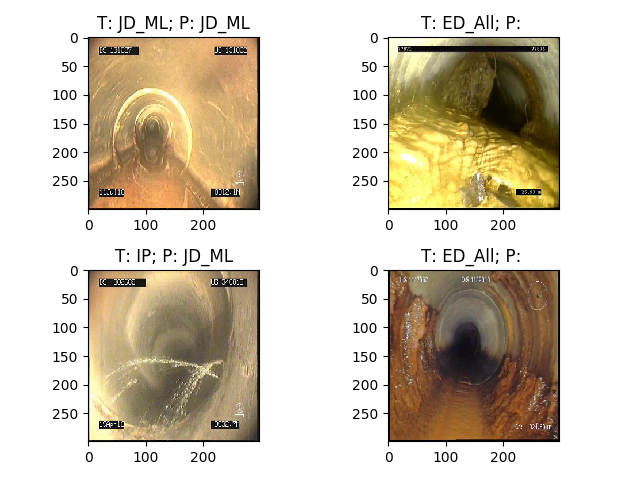

182/182 [==============================] - 22s 122ms/step


In [32]:
def multi_label_decision(y_true, y_pred, thresh=0.5):
    return (y_true > thresh) == (y_pred > thresh)
def single_label_decision(y_true, y_pred):
    return np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1)

decision_function = single_label_decision if caption_type == 'single' else multi_label_decision
thresh = 0.5 # Used for multi-label decisions

Y_true = test_data[1]
Y_pred = model.predict(test_data[0])
TP = decision_function(Y_true, Y_pred)
print("Test accuracy for {:d} samples: {:.2f}".format(len(test_data[0]), np.count_nonzero(TP) / TP.size))
for i, (image, true_caption, pred_caption) in enumerate(zip(test_data[0], test_data[1], Y_pred)):
    if i % 4 == 0:
        if i > 0:
            plt.tight_layout()
        if i >= 4:
            break
        if i < len(test_data[0]):
            plt.figure()
    plt.subplot(2, 2, 1 + (i % 4))
    plt.imshow(postprocess(image))
    plt.title("T: {:s}; P: {:s}".format(
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
    ))
test_metrics = model.evaluate(test_data[0], test_data[1]);

# Save model (pretty important!)

In [35]:
def save_model(model, name, class_map_r, prediction_type,
               model_weights_path, model_def_path, model_info_path,
               test_metrics=None, description=""):
    def merged(a, b):
        merged = dict(a)
        merged.update(b)
        return merged
        
    # Encountered JSON TypeError when parsing np.float32
    # Works for np.float64 or float
    json_allowable_history = train_history.history
    json_allowable_history['lr'] = [float(lr) for lr in train_history.history['lr']]
    model_info = {
        "name": name,
        "description": description,
        "weights": model_weights_path,
        "prediction_type": caption_type,
        "model": model_def_path,
        "classes": class_map_r,
        "architecture": {
            "backbone": "inceptionv3",
            "logit_activation": model.get_layer("class_logits").activation.__name__,
            "input_shape": image_dims
        },
        "metrics": {
            "loss_function": train_history.model.loss,
            "train": merged(
                train_history.history,
                {
                    "epoch": train_history.epoch,
                    "params": train_history.params
                })
        }
    }
    if test_metrics:
        model_info['metrics']['test'] = test_metrics
    
    print("Writing model def to " + model_def_path)
    with open(model_def_path, "w") as file:
        file.write(model.to_json())
        
    print("Writing model weights to " + model_weights_path)
    model.save_weights(model_weights_path)
    
    print("Writing model info to " + model_info_path)
    with open(model_info_path, "w") as file:
        file.write(json.dumps(model_info))
    



In [68]:
# x = [r for r in train_history.history['lr']]
# print(json.dumps(x[0].astype(float)))
# print(json.dumps(x[0].astype(np.float64)))
# x[0]
# type(x[0])
# type(1e-4)
# json.dumps([1e-04,1e-4])

9.999999747378752e-05
9.999999747378752e-05


In [29]:
log_dir

'/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/'

In [36]:
# Fill in the relevant params below 
# log_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/single/run-1-restarted/"
model_def_path = os.path.join(log_dir, "model_def.json")
model_weights_path = os.path.join(log_dir, "model_weights.h5")
model_info_path = os.path.join(log_dir, "model.json")
save_model(
    model, name="all-classes-no-bg",
    class_map_r=caption_map_r, prediction_type=caption_type,
    model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
    test_metrics=test_metrics,
    description="All classes no background class"
)

Writing model def to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/model_def.json
Writing model weights to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/model_weights.h5
Writing model info to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/no-bg/multi/all-classes/model.json
